In [1]:
# Voici l'ensemble de modules Python dont nous allons avoir besoin 
# Vérifions l'installation avant et également a priori on fait du Python 3
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
print('modules chargés')

modules chargés


D'abord, nous allons télécharger l'ensemble des données sur notre machine locale. Les données se composent de caractères générés dans une variété de polices de caractères sur une image 28x28 (comme MNISTà. 
Les étiquettes sont limitées aux classes'A' à'J' (10 classes). 
Le jeu de données d'entraînement a environ 500k et le jeu de tests 19.000 exemples étiquetés. Compte tenu de ces dimensions, il devrait être possible de former rapidement les modèles sur n'importe quelle machine.


In [2]:
# On définit une fonction qui télécharge si les données ne sont pas présentes
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes, force=False):
  """ Télécharge un fichier s'il n'est pas présent et vérification de la taille """
  if force or not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Trouvé et vérifié ', filename)
  else:
    raise Exception(
      'N\'a pu être vérifié' + filename + '. Obtenez-le à l\'aide d\'un navigateur !')
  return filename
train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Trouvé et vérifié  notMNIST_large.tar.gz
Trouvé et vérifié  notMNIST_small.tar.gz


Extraire l'ensemble de données du fichier.tar.gz compressé. Cela devrait vous donner un ensemble de répertoires, étiquetés de A à J.

In [3]:

num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s déjà présent - on "skip" l\'extraction de %s.' % (root, filename))
  else:
    print('Extractiion des data pour %s. Cela peut prendre du temps. Patientez svp.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders

# on crée deux dossiers à partir des deux jeux de données que l'on a rapatriés
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)



notMNIST_large déjà présent - on "skip" l'extraction de notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small déjà présent - on "skip" l'extraction de notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


## 1. Première tâche : acquérir et préparer des données

Examinons à certaines données pour nous assurer qu'elles semblent correctes. 
Chaque exemplaire doit être une image d'une instance de A à J générée dans une police de caractères différente. Afficher un échantillon des images que nous venons de télécharger. Astuce : vous pouvez utiliser le paquet IPython.display.


In [4]:
#Auparavant une importation de quelques librairies
import random
import hashlib
%matplotlib inline


In [5]:

# affichage de quelques données
def disp_samples(data_folders, sample_size):
  for folder in data_folders:
    print(folder)
    image_files = os.listdir(folder)
    image_sample = random.sample(image_files, sample_size)
    for image in image_sample:
      image_file = os.path.join(folder, image)
      i = Image(filename=image_file)
      display(i)



In [6]:
disp_samples(train_folders, 1)

notMNIST_large/A


notMNIST_large/B


notMNIST_large/C


notMNIST_large/D


notMNIST_large/E


notMNIST_large/F


notMNIST_large/G


notMNIST_large/H


notMNIST_large/I


notMNIST_large/J


### Creation de donnees sous un format pickle


Maintenant, il s'agit de charger les données dans un format plus facile à gérer. 
Puisque, selon la configuration de votre ordinateur, il se peut que vous ne puissiez pas tout mettre en mémoire, nous chargerons chaque classe dans un jeu de données séparé, les stockerons sur disque et les conserverons indépendamment. Plus tard, nous les fusionnerons en un seul ensemble de données de taille gérable.

Nous convertirons l'ensemble des données vers un tableau 3D (indice d'image, x, y) à valeurs réelles, normalisées pour avoir une moyenne d'environ zéro et un écart type ~0,5 pour faciliter l'entraînement en cours de route.

Quelques images ne sont peut-être pas lisibles, on va juste les enlever.


In [7]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """ Chargement des data pour une etiquette d'une seule lettre."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
  image_index = 0
  print(folder)
  for image in os.listdir(folder):
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :] = image_data
      image_index += 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- c\'est ok, on passe.')
    
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s deja present - on passe le pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle deja present - on passe le pickling.
notMNIST_large/B.pickle deja present - on passe le pickling.
notMNIST_large/C.pickle deja present - on passe le pickling.
notMNIST_large/D.pickle deja present - on passe le pickling.
notMNIST_large/E.pickle deja present - on passe le pickling.
notMNIST_large/F.pickle deja present - on passe le pickling.
notMNIST_large/G.pickle deja present - on passe le pickling.
notMNIST_large/H.pickle deja present - on passe le pickling.
notMNIST_large/I.pickle deja present - on passe le pickling.
notMNIST_large/J.pickle deja present - on passe le pickling.
notMNIST_small/A.pickle deja present - on passe le pickling.
notMNIST_small/B.pickle deja present - on passe le pickling.
notMNIST_small/C.pickle deja present - on passe le pickling.
notMNIST_small/D.pickle deja present - on passe le pickling.
notMNIST_small/E.pickle deja present - on passe le pickling.
notMNIST_small/F.pickle deja present - on passe le pickling.
notMNIST_small/G.pickle 

## 2. Tâche 2 : vérifier si les données sont bien manipulables

Vérifions que les données sont toujours bonnes. Affichage d'un échantillon des étiquettes et des images du tableau numpy. 

Pour ce faire on va utiliser matplotlib.pyplot.

In [8]:
def disp_8_img(imgs, titles):
  """Display subplot with 8 images or less"""
  for i, img in enumerate(imgs):
    plt.subplot(2, 4, i+1)
    plt.title(titles[i])
    plt.axis('off')
    plt.imshow(img)

def disp_sample_pickles(data_folders):
  folder = random.sample(data_folders, 1)
  pickle_filename = ''.join(folder) + '.pickle'
  try:
    with open(pickle_filename, 'rb') as f:
      dataset = pickle.load(f)
  except Exception as e:
    print('Unable to read data from', pickle_filename, ':', e)
    return
  # display
  plt.suptitle(''.join(folder)[-1])

  for i, img in enumerate(random.sample(list(dataset), 8)):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(img)

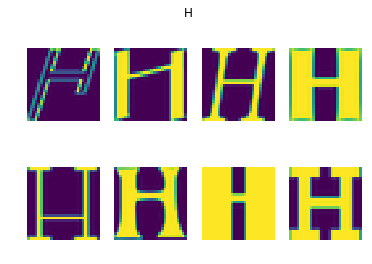

In [9]:
# on affiche quelques exemples des données d'entrainement
disp_sample_pickles(train_folders)

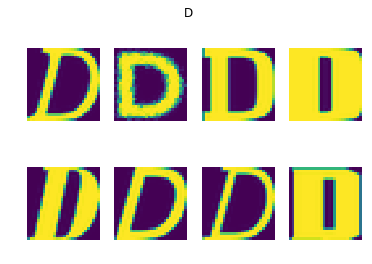

In [10]:
# on affiche quelques exemples des données test
disp_sample_pickles(test_folders)

## Tâche 3 : Une autre vérification des données, vérifions que c'est équilibré entre les classes.


Les données sont équilibrées d'une classe à l'autre si les classes ont à peu près le même nombre d'éléments. Vérifions le nombre d'images par classe

In [11]:
def disp_number_images(data_folders):
  for folder in data_folders:
    pickle_filename = ''.join(folder) + '.pickle'
    try:
      with open(pickle_filename, 'rb') as f:
        dataset = pickle.load(f)
    except Exception as e:
      print('Impossible de lire les donnees de', pickle_filename, ':', e)
      return
    print('Nombre d\'images dans ', folder, ' : ', len(dataset))
    
disp_number_images(train_folders)
disp_number_images(test_folders)


Nombre d'images dans  notMNIST_large/A  :  52909
Nombre d'images dans  notMNIST_large/B  :  52911
Nombre d'images dans  notMNIST_large/C  :  52912
Nombre d'images dans  notMNIST_large/D  :  52911
Nombre d'images dans  notMNIST_large/E  :  52912
Nombre d'images dans  notMNIST_large/F  :  52912
Nombre d'images dans  notMNIST_large/G  :  52912
Nombre d'images dans  notMNIST_large/H  :  52912
Nombre d'images dans  notMNIST_large/I  :  52912
Nombre d'images dans  notMNIST_large/J  :  52911
Nombre d'images dans  notMNIST_small/A  :  1872
Nombre d'images dans  notMNIST_small/B  :  1873
Nombre d'images dans  notMNIST_small/C  :  1873
Nombre d'images dans  notMNIST_small/D  :  1873
Nombre d'images dans  notMNIST_small/E  :  1873
Nombre d'images dans  notMNIST_small/F  :  1872
Nombre d'images dans  notMNIST_small/G  :  1872
Nombre d'images dans  notMNIST_small/H  :  1872
Nombre d'images dans  notMNIST_small/I  :  1872
Nombre d'images dans  notMNIST_small/J  :  1872


Il n'y a que des écarts minimes, de sorte que les classes sont bien équilibrées.

## Tâche 3-bis: données de validation

Fusionner et élaguer les données d'entrainement selon les besoins. 

Selon la configuration de l'ordinateur utilisé, il se peut que l'on ne puisse tout charger en mémoire, et on doit alors  régler `train_size` selon les possibilités. 

Les étiquettes seront stockées dans un tableau distinct d'entiers de 0 à 9.

Il nous faut créer également un ** jeu de données de validation** pour le réglage des hyperparamètres du modèle.

In [12]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Ensuite, nous allons mélanger les données. 

Il est important que les étiquettes soient bien mélangées pour que les distributions d'entrainement et de tests puissent correspondre.

In [13]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Tâche 4 : On va contrôler que les données sont encore valables après mélange !

Pour être sûr que les données sont encore bonnes après la fusion et la randomisation,
on sélectionne un item et on l'affiche l'image avec le label associé

Note: 0 = A, 1 = B, 2 = C, 3 = D, 4 = E, 5 = F, 6 = G, 7 = H, 8 = I, 9 = J.


In [14]:

# un petit dictionnaire
pretty_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}

def disp_sample_dataset(dataset, labels):
  items = random.sample(range(len(labels)), 8)
  for i, item in enumerate(items):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.title(pretty_labels[labels[item]])# le titre est la lettre convertie à partir du chiffre
    plt.imshow(dataset[item])

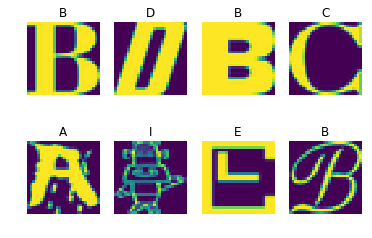

In [15]:
# examen du jeu de données d'entrainement
disp_sample_dataset(train_dataset, train_labels)

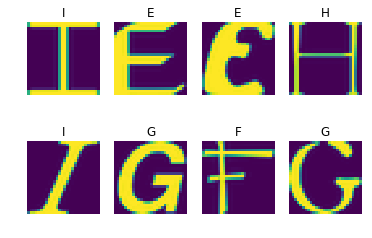

In [16]:
# examen du jeu de données de validité  (celui qui sert pour le réglage des hyperparamèetres)
disp_sample_dataset(valid_dataset, valid_labels)

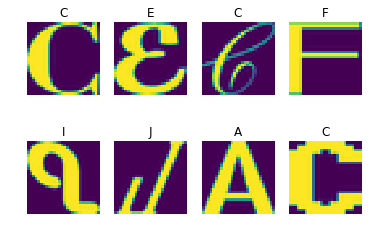

In [17]:
# examen du jeu de données de test
disp_sample_dataset(test_dataset, test_labels)

Si tout est correct, on va sauvergarder ce jeu de donnnées pour utilisation future éventuelle.

In [18]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Impossible de sauvegarder ', pickle_file, ':', e)
  raise


In [19]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800512


## Tâche 5 : curation des données


Par construction, cet ensemble de données pourrait contenir des échantillons qui se chevauchent, y compris les données d'entrainement qui sont également contenues dans l'ensemble de validation et de test ! Le chevauchement entre l' entrainement et le test peut fausser les résultats si vous vous attendez à utiliser votre modèle dans un environnement où il n'y a jamais de chevauchement, mais vous pouvez le faire si vous vous attendez à voir des échantillons de formation réapparaître lorsque vous l'utilisez. 

Mesurer le chevauchement entre la formation, la validation et les échantillons d'essai.
+  Qu'en est-il des quasi-doublons entre les ensembles de données ? (images presque identiques)
+ On va créer  un ensemble de validation et de tests aseptisés, et ce précision pourra être utile pour la suite

In [20]:
# fonction qui affiche le chevauchement
def display_overlap(overlap, source_dataset, target_dataset):
  item = random.choice(list(overlap.keys()))  # list(d.keys())
  imgs = np.concatenate(([source_dataset[item]], target_dataset[overlap[item][0:7]]))
  plt.suptitle(item)
  for i, img in enumerate(imgs):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(img)

In [21]:
# fonction qui effectue une extraction
def extract_overlap(dataset_1, dataset_2):
  overlap = {} # dictionnaire
  for i, img_1 in enumerate(dataset_1):
    for j, img_2 in enumerate(dataset_2):     
      if np.array_equal(img_1, img_2):
        if not i in overlap.keys():
          overlap[i] = []
        overlap[i].append(j)
  return overlap

In [22]:
# un petit test pour voir combien de temps cela prend

In [ ]:
%time overlap_test_train = extract_overlap(test_dataset[:200], train_dataset)

In [ ]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

La fonction `display_overlap` ci-dessus affiche l'un des doublons, le premier élément provient du premier ensemble de données et les suivants proviennent de l'ensemble de données utilisé pour la comparaison.

Maintenant que les duplicatas exacts ont été trouvés, recherchons les duplicatas proches. Comment définir des images presque identiques ? C'est une question délicate. Une des premières idées a été d'utiliser la comparaison de matrices numpy tout près. Ceci est trop restrictif, car deux images peuvent varier d'un pixel, et rester très similaires même si la variation sur le pyxel est importante. Une meilleure solution implique une sorte de moyenne.

Pour rester simple et toujours pertinent, on va utiliser une norme de Manhattan (somme des valeurs absolues) de la matrice des différences. Comme les images de l'ensemble de données ont toutes la même taille, on ne normalise normaliser la valeur normale. Noter qu'il s'agit d'une comparaison pixel par pixel, et donc il n'évoluera pas à l'échelle de l'ensemble des données, mais il aidera à comprendre les similitudes d'image.

### overlap near

In [ ]:
MAX_MANHATTAN_NORM = 10

def extract_overlap_near(dataset_1, dataset_2):
  overlap = {}
  for i, img_1 in enumerate(dataset_1):
    for j, img_2 in enumerate(dataset_2):
      diff = img_1 - img_2
      m_norm = np.sum(np.abs(diff))
      if m_norm < MAX_MANHATTAN_NORM:
        if not i in overlap.keys():
          overlap[i] = []
        overlap[i].append(j)
  return overlap

In [ ]:
%time overlap_test_train_near = extract_overlap_near(test_dataset[:200], train_dataset)

In [ ]:
print('Number of near overlaps:', len(overlap_test_train_near.keys()))
display_overlap(overlap_test_train_near, test_dataset[:200], train_dataset)

Les techniques ci-dessus fonctionnent bien, mais les performances sont médiocres et les méthodes sont peu extensibles à l'ensemble des données. 

Essayons d'améliorer les performances. Prenons quelques temps de référence sur un petit ensemble de données.

Voici quelques idées :

    + arrêter à un une première occurence
    + utilisation de fonction nympique where dans l'ensemble de données diff.
    + comparaison par hachage

### overlap stop

In [ ]:
def extract_overlap_stop(dataset_1, dataset_2):
  overlap = {}
  for i, img_1 in enumerate(dataset_1):
    for j, img_2 in enumerate(dataset_2):     
      if np.array_equal(img_1, img_2):
        overlap[i] = [j]
        break
  return overlap

In [ ]:
%time overlap_test_train = extract_overlap_stop(test_dataset[:200], train_dataset)

In [ ]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

### overlap where

In [ ]:
MAX_MANHATTAN_NORM = 10

def extract_overlap_where(dataset_1, dataset_2):
  overlap = {}
  for i, img_1 in enumerate(dataset_1):
    diff = dataset_2 - img_1
    norm = np.sum(np.abs(diff), axis=1)
    duplicates = np.where(norm < MAX_MANHATTAN_NORM)
    if len(duplicates[0]):
      overlap[i] = duplicates[0]
  return overlap

In [ ]:
test_flat = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
train_flat = train_dataset.reshape(train_dataset.shape[0], 28 * 28)
%time overlap_test_train = extract_overlap_where(test_flat[:200], train_flat)

In [ ]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

### overlap hash

The built-in numpy function provides some improvement either, but this algorithm is still not scalable to the dataset to its full extend.

To make it work at scale, the best option is to use a hash function. To find exact duplicates, the hash functions used for the cryptography will work just fine.


In [ ]:
def extract_overlap_hash(dataset_1, dataset_2):
  dataset_hash_1 = [hashlib.sha256(img).hexdigest() for img in dataset_1]
  dataset_hash_2 = [hashlib.sha256(img).hexdigest() for img in dataset_2]
  overlap = {}
  for i, hash1 in enumerate(dataset_hash_1):
    for j, hash2 in enumerate(dataset_hash_2):
      if hash1 == hash2:
        if not i in overlap.keys():
          overlap[i] = []
        overlap[i].append(j) ## use np.where
  return overlap

In [ ]:
%time overlap_test_train = extract_overlap_hash(test_dataset[:200], train_dataset)

In [ ]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)


D'autres valeurs se chevauchant ont pu être trouvées, ceci est dû aux collisions de hachage. Plusieurs images peuvent avoir le même hash mais sont en réalité différentes. Ceci n'est pas remarqué ici, et même si cela se produit, c'est acceptable. Tous les doublons seront supprimés à coup sûr.

Nous pouvons rendre le traitement a mais plus rapide en utilisant la fonction numpy `where`  intégrée.


In [ ]:
def extract_overlap_hash_where(dataset_1, dataset_2):
  dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
  dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
  overlap = {}
  for i, hash1 in enumerate(dataset_hash_1):
    duplicates = np.where(dataset_hash_2 == hash1)
    if len(duplicates[0]):
      overlap[i] = duplicates[0]
  return overlap

In [ ]:
%time overlap_test_train = extract_overlap_hash_where(test_dataset[:200], train_dataset)

In [ ]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

D'un certain point de vue (auteur du notebookl), les doublons proches devraient également être supprimés dans les ensembles de données aseptisés. L'hypothèse serait que les duplicatas "proches" sont très proches (parfois il n'y a qu'une seule frontière pixel de différence), et pénalisent l'entraînement de la même manière que les vrais duplicatas.

Cela dit, trouver des doublons proches avec une fonction de hachage n'est pas évident. Il existe des techniques pour cela, comme le "hachage sensible localement", le "hachage perceptuel" ou le "hachage par différence". Il y a même une bibliothèque Python disponible. 

Les données aseptisées générées ci-dessous sont basées sur des duplicatas réels trouvés avec une fonction de hachage cryptographique.
Pour nettoyer l'ensemble de données, on change la fonction ci-dessus en renvoyant directement l'ensemble de données propres.

In [ ]:
# fonction nettoyage
def sanetize(dataset_1, dataset_2, labels_1):
  dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
  dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
  overlap = [] # list of indexes
  for i, hash1 in enumerate(dataset_hash_1):
    duplicates = np.where(dataset_hash_2 == hash1)
    if len(duplicates[0]):
      overlap.append(i) 
  return np.delete(dataset_1, overlap, 0), np.delete(labels_1, overlap, None)

In [ ]:
%time test_dataset_sanit, test_labels_sanit = sanetize(test_dataset[:200], train_dataset, test_labels[:200])
print('Overlapping images removed: ', len(test_dataset[:200]) - len(test_dataset_sanit))

Même chose avec le dataset entier

In [ ]:
%time test_dataset_sanit, test_labels_sanit = sanetize(test_dataset, train_dataset, test_labels)
print('Overlapping images removed: ', len(test_dataset) - len(test_dataset_sanit))

In [ ]:
%time valid_dataset_sanit, valid_labels_sanit = sanetize(valid_dataset, train_dataset, valid_labels)
print('Overlapping images removed: ', len(valid_dataset) - len(valid_dataset_sanit))

#### on fait maintenant la sauvegarde dans un dataset local

In [ ]:
# création des fichiers
pickle_file_sanit = 'notMNIST_sanit.pickle'

try:
  f = open(pickle_file_sanit, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset_sanit,
    'valid_labels': valid_labels_sanit,
    'test_dataset': test_dataset_sanit,
    'test_labels': test_labels_sanit,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [ ]:
# quelques stats de vérification
statinfo = os.stat(pickle_file_sanit)
print('Compressed pickle size:', statinfo.st_size)

** Ca y est on a des données !!! ***
*** Noter  que c'est un travail important. ***

## Tâche 6 : faire tourner un modèle sur ces données

Voyons ce qui se passe avec un classificateur standard  sur ces données. Il est toujours bon de vérifier qu'il y a quelque chose à apprendre, et que c'est un problème qui n'est pas si trivial qu'une solution immédiate le résout.

Former un modèle simple sur ces données en utilisant 50, 100, 1000 et 5000 échantillons d'apprentissage. 



### On va utiliser le modèle LogisticRegression de sklearn.linear_model.

In [ ]:
regr = LogisticRegression()
X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
y_test = test_labels


#### première expérience (50)

In [ ]:
sample_size = 50
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

In [ ]:
pred_labels = regr.predict(X_test)
disp_sample_dataset(test_dataset, pred_labels) # 

#### deuxième expérience (100)

In [ ]:
sample_size = 100
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

In [ ]:
sample_size = 1000
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

In [ ]:
X_valid = valid_dataset[:sample_size].reshape(sample_size, 784)
y_valid = valid_labels[:sample_size]
regr.score(X_valid, y_valid)

In [ ]:
pred_labels = regr.predict(X_valid)
disp_sample_dataset(valid_dataset, pred_labels)

#### troisième expérience (5000)

In [ ]:
sample_size = 5000
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

Pour entrainer le modèle sur toutes les données, nous devons utiliser un autre solveur. SAG est le plus rapide.

In [ ]:
regr2 = LogisticRegression(solver='sag')
sample_size = len(train_dataset)
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr2.fit(X_train, y_train)
regr2.score(X_test, y_test)

In [ ]:
pred_labels = regr.predict(X_test)
disp_sample_dataset(test_dataset, pred_labels)

La précision peut être faible par rapport à un réseau neuronal profond, mais en tant que première technique de reconnaissance de caractères, c'est déjà pas mal !